# 01_Basics.ipynb

## Title: "Setting Up and Basic Data Retrieval"

### Contents:
- Importing libraries.
- Functions for data retrieval and flattening.
- API requests to SEC for company data.
- Data inspection and manipulation.

---

```python
# -*- coding: utf-8 -*-
"""
U.S. Securities and Exchange Commission (SEC) Scraper
@author: ByteQuester
"""

# Set Up the Environment

## Import Libraries

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

## Functions

### Flattening Data

In [2]:
def flatten_multiple_metrics(response_json, metric_names, unit='USD'):
    """
    Flatten the data for multiple metrics and a specified unit from the SEC API response.

    Parameters:
    response_json (dict): The JSON response from the SEC API.
    metric_names (list of str): The names of the metrics to flatten (e.g., ['NetIncomeLoss', 'Revenues']).
    unit (str): The unit of the metrics (default is 'USD').

    Returns:
    pd.DataFrame: A DataFrame containing the flattened data for all specified metrics.
    """
    all_flattened_data = []

    for metric_name in metric_names:
        metric_data = response_json.get('facts', {}).get('us-gaap', {}).get(metric_name, None)

        if not metric_data or unit not in metric_data['units']:
            continue  # Skip the metric if not found or if the unit is not present

        flattened_data = [
            {
                'EntityName': response_json.get('entityName'),
                'CIK': response_json.get('cik'),
                'Metric': metric_name,
                **item
            }
            for item in metric_data['units'][unit]
        ]

        all_flattened_data.extend(flattened_data)

    return pd.DataFrame(all_flattened_data)
    
## # Example usage with multiple metrics
# metrics = ['NetIncomeLoss', 'Revenues', 'OperatingIncomeLoss']
# combined_df = flatten_multiple_metrics(response.json(), metrics)

# Data Retrieval

## Get All Companies Data

In [3]:
headers = {'User-Agent': 'YourName <your_email@example.com>'}
companyTickers = requests.get("https://www.sec.gov/files/company_tickers.json", headers=headers)
companyData = pd.DataFrame.from_dict(companyTickers.json(), orient='index')
companyData['cik_str'] = companyData['cik_str'].astype(str).str.zfill(10)
print(companyData.head())

      cik_str ticker           title
0  0000320193   AAPL      Apple Inc.
1  0000789019   MSFT  MICROSOFT CORP
2  0001652044  GOOGL   Alphabet Inc.
3  0001018724   AMZN  AMAZON COM INC
4  0001045810   NVDA     NVIDIA CORP


## Retrieve Company Specific Filing Metadata

In [4]:
cik = companyData.iloc[0]['cik_str']  # Example CIK, replace with desired company's CIK
filingMetadata = requests.get(f'https://data.sec.gov/submissions/CIK{cik}.json', headers=headers)
allForms = pd.DataFrame.from_dict(filingMetadata.json()['filings']['recent'])
print(allForms[['accessionNumber', 'reportDate', 'form']].head(10))

        accessionNumber  reportDate  form
0  0000320193-23-000113  2023-11-29     4
1  0000320193-23-000111  2023-11-16     4
2  0000320193-23-000109  2023-11-10     4
3  0000320193-23-000106  2023-09-30  10-K
4  0000320193-23-000104  2023-11-02   8-K
5  0000320193-23-000099  2023-10-15     4
6  0000320193-23-000097  2023-10-06     4
7  0000320193-23-000096  2023-10-06     4
8  0001958244-23-001819               144
9  0001958244-23-001817               144


## Retrieve Company Facts Data

In [5]:
cik='0000012927'

In [6]:
companyFacts = requests.get(f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json', headers=headers)
print(companyFacts.json().keys())  # Display the keys to understand the structure

dict_keys(['cik', 'entityName', 'facts'])


## Retrieve Company Concept Data

In [7]:
companyConcept = requests.get(f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/us-gaap/Assets.json', headers=headers)
assetsData = pd.DataFrame.from_dict(companyConcept.json()['units']['USD'])
assets10Q = assetsData[assetsData.form == '10-Q'].reset_index(drop=True)

## Save Data for Analysis 

In [8]:
# change these metrics for subsequent notebooks and further analysis
#metrics = ['Revenues', 'PropertyPlantAndEquipmentNet']
#metrics = ['CapitalExpendituresIncurredButNotYetPaid', 'NetIncomeLoss', 'Assets'] # Investment Efficiency
#metrics = ['AssetsCurrent', 'LiabilitiesCurrent'] # Liquidity
#metrics = ['Assets', 'Liabilities', 'StockholdersEquity'] # Assets and Liabilities
#metrics = ['OperatingIncomeLoss', 'Revenues', 'NetIncomeLoss'] # Profitability
metrics = ['NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInFinancingActivities'] # Cash Flow 

In [9]:
combined_df = flatten_multiple_metrics(companyFacts.json(), metrics)

In [10]:
combined_df.to_csv('combined_df.csv', index=False)

# Data Visualization

## Plotting Assets Over Time from 10-Q Forms

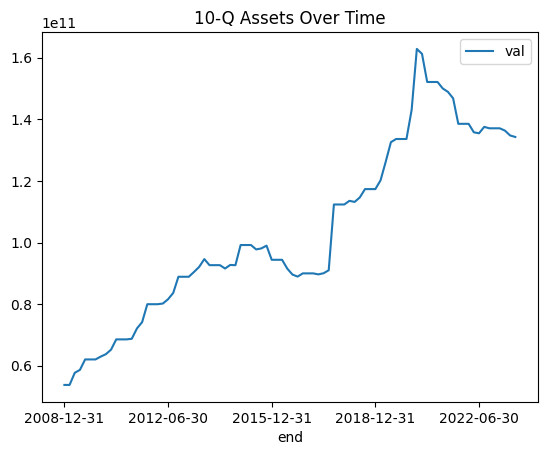

In [11]:
assets10Q.plot(x='end', y='val', title='10-Q Assets Over Time')
plt.show()

# Conclusion and Next Steps